<a href="https://colab.research.google.com/github/halilyaman/neural_network_implementation/blob/master/NN_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Import libraries**

In [0]:
import numpy as np
import time
import matplotlib.pyplot as plt

# **Activations class**
This class contains activation functions and derivatives of them. All functions are static in order to use them directly in a neural network. \
X represents the input matrix.

In [0]:
class Activations:

  @staticmethod
  def sigmoid(X):

    return 1 / (1 + np.exp(-X))

  @staticmethod
  def linear(X):

    return X

  @staticmethod
  def relu(X):

    return np.maximum(0, X)

  @staticmethod
  def leaky_relu(X):

    return np.maximum(0.01 * X, X)

  @staticmethod
  def tanh(X):

    return np.tanh(X)

  @staticmethod
  def sigmoid_derivative(X):

    X_sigmoid = Activations.sigmoid(X)

    return X_sigmoid * (1 - X_sigmoid)

  @staticmethod
  def relu_derivative(X):
    
    derivatives = np.zeros(X.shape)

    for i, rows in enumerate(X):

      for j, v in enumerate(rows):

        if v < 0:
          derivatives[i, j] = 0
        else:
          derivatives[i, j] = 1

    return derivatives

  @staticmethod
  def leaky_relu_derivative(X):
    
    derivatives = np.zeros(X.shape)

    for i, rows in enumerate(X):

      for j, v in enumerate(rows):

        if v < 0:
          derivatives[i, j] = 0.01
        else:
          derivatives[i, j] = 1

    return derivatives

  @staticmethod
  def tanh_derivative(X):

    tanh = Activations.tanh(X)
    
    return 1 - tanh ** 2

# **Layer class**

In [0]:
class Layer:

  def __init__(self, units, input_shape=None, activation="linear"):

    self.units = units
    self.input_shape = input_shape
    self.activation = activation
    self.layer_type = None
    self.predictions = None
    self.inputs = None
    self.learning_rate = None
    self.next_layer = None
    self.activation_derivative = None
    self.z_1 = None

    if not(self.input_shape == None):
      self.__init_weights()
  
  def __init_weights(self,):

    self.w = np.random.rand(self.units, self.input_shape[0])
    self.b = np.zeros((self.units, 1))

  def _forward_prop(self, X):

    if X.shape[0] != self.input_shape[0]:
      raise Exception("input shape doesn't match with the data!")

    self.inputs = X

    dot_products = np.dot(self.w, X)
    pred = dot_products + self.b
    self.z_1 = pred
    self.predictions = self._choose_activation(pred)

    return self.predictions
  
  def _backward_prop(self, Y):

    avg_factor = (1 / len(self.inputs))

    # derivative calculations are different in order to layer type.
    # So we need these conditions
    if self.layer_type == "output_layer":

      # calculating new weights and b values
      self.d_z = self.predictions - Y
      d_w = avg_factor * self.d_z.dot(self.inputs.T)
      d_b = avg_factor * np.sum(self.d_z, axis=1, keepdims=True)
      
      # updating weights and b
      self.b = self.b - self.learning_rate * d_b
      self.w = self.w - self.learning_rate * d_w
    
    if self.layer_type == "hidden_layer":

      # calculating new weights and b values
      self.d_z = self.next_layer.w.T.dot(self.next_layer.d_z) * self.activation_derivative(self.z_1)
      d_w = avg_factor * self.d_z.dot(self.inputs.T)
      d_b = avg_factor * np.sum(self.d_z, axis=1, keepdims=True)

      # updating weights and b
      self.b = self.b - self.learning_rate * d_b
      self.w = self.w - self.learning_rate * d_w


  def _choose_activation(self, X):

    if self.activation == "sigmoid":
      X = Activations.sigmoid(X)
      self.activation_derivative = Activations.sigmoid_derivative
    
    elif self.activation == "linear":
      X = Activations.linear(X)
    
    elif self.activation == "relu":
      X = Activations.relu(X)
      self.activation_derivative = Activations.relu_derivative

    elif self.activation == "leaky_relu":
      X = Activations.leaky_relu(X)
      self.activation_derivative = Activations.leaky_relu_derivative

    elif self.activation == "tanh":
      X = Activations.tanh(X)
      self.activation_derivative = Activations.tanh_derivative

    return X
    
  def _bind_to(self, layer):

    self.input_shape = (layer.units, 1)
    self.__init_weights()

  def _set_layer_type(self, layer_type):

    self.layer_type = layer_type

  def _set_learning_rate(self, learning_rate):
    
    self.learning_rate = learning_rate

# **Model class**

In [0]:
class MyModel:
  
  def __init__(self, learning_rate=0.01):

    self.layers = list()
    self.learning_rate = learning_rate
    self.history = dict()


  def add_layer(self, layer):

    if len(self.layers) == 0:

      self.layers.append(layer)
      self.layers[0]._set_layer_type("output_layer")

    else:

      layer._bind_to(self.layers[-1])
      self.layers[-1].next_layer = layer
      self.layers.append(layer)
      

      n = len(self.layers)
      last_layer_i = n - 1
      before_last_i = n - 2

      self.layers[last_layer_i]._set_layer_type("output_layer")
      self.layers[before_last_i]._set_layer_type("hidden_layer")

    self.layers[-1]._set_learning_rate(self.learning_rate)


  def fit(self, X, Y, epochs, verbose=True):

    self.history["loss"] = []
    m = len(Y)

    for i in range(epochs):

      if verbose:
        print("Epoch {}\n".format(i+1))
  
      current_output = X
      for j in self.layers:

        current_output = j._forward_prop(current_output)
      
      for j in reversed(range(len(self.layers))):

        self.layers[j]._backward_prop(Y)
      
      logprobs = np.multiply(np.log(current_output.flatten()), Y) + np.multiply(np.log(1-current_output.flatten()), (1-Y))
      cost = - np.sum(logprobs) / m
      
      self.history["loss"].append(cost)


  def predict(self, X):

    current_output = X
    for i in self.layers:

      current_output = i._forward_prop(current_output)
    
    return current_output

  
  def print_layers(self,):
    print("\n****************************\n")

    for i, v in enumerate(self.layers):
      print("Layer Index: {}\nLayer Type: {}\nUnits: {}\nActivation: {}\n"
      .format(i, v.layer_type, v.units, v.activation, v.input_size))
    
    print("****************************\n")


In [49]:

# X and Y are dummy datas which represent the XOR operation.
X = np.array([[1, 1], [1, 0], [0, 1], [0, 0]]).T
Y = np.array([0, 1, 1, 0])
print(X.shape)
# get the current time
past = time.time()

# create the model with learning_rate as a parameter
model = MyModel(learning_rate=0.1)

# create layers
layer_1 = Layer(units=4, input_shape=(2, 1), activation="tanh")
layer_2 = Layer(units=1, activation="sigmoid")

# add layers to the model
model.add_layer(layer_1)
model.add_layer(layer_2)

# fit the data to the model
model.fit(X, Y, 2000, verbose=False)

# get prediction after fitting the data
# use same data as we used in fitting process
predictions = model.predict(X)

# calculate the accuracy percentage of the predictions
accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)

print("Results after fitting:\n", after_fit)
print("\nAccuracy: {}%".format(accuracy))
print("\nTime passed: {} seconds".format(time.time() - past))

(2, 4)
Results after fitting:
 [[0.03386414]
 [0.97744239]
 [0.97891174]
 [0.00428964]]

Accuracy: 98.46641312244603%

Time passed: 0.16193914413452148 seconds


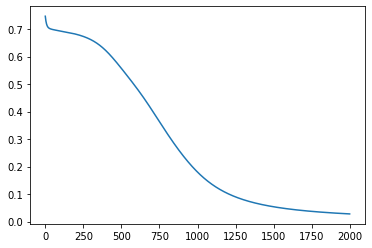

In [14]:
plt.plot(model.history["loss"])

In [51]:
# same dummy data as before we used
X = np.array([[1, 1], [1, 0], [0, 1], [0, 0]]).T
Y = np.array([0, 1, 1, 0])

# number of units in a hidden layer
unit_numbers = [1, 2, 3, 4, 5, 10, 20, 50, 100]

# try each number of hidden units in the for loop and
# print the accuracy for each one
# epoch is defined as 1000
for n_hidden_units in unit_numbers:

  model = MyModel(0.1)

  layer_1 = Layer(units=n_hidden_units, input_shape=(2, 1), activation="tanh")
  layer_2 = Layer(units=1, activation="sigmoid")

  model.add_layer(layer_1)
  model.add_layer(layer_2)

  model.fit(X, Y, epochs=1000, verbose=False)

  predictions = model.predict(X)

  accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)

  print("Accuracy for {} hidden units: {}%".format(n_hidden_units, accuracy))

Accuracy for 1 hidden units: 66.16058159748553%
Accuracy for 2 hidden units: 97.02922579728171%
Accuracy for 3 hidden units: 96.5205345303777%
Accuracy for 4 hidden units: 96.63291050169838%
Accuracy for 5 hidden units: 96.49812711822749%
Accuracy for 10 hidden units: 96.105484108208%
Accuracy for 20 hidden units: 96.60991405851951%
Accuracy for 50 hidden units: 96.85797035549724%
Accuracy for 100 hidden units: 98.68565859730916%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log
